### Для запуска

In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
from torch import nn,manual_seed,from_numpy, split, tensor
import torch.optim as optim
import torch
import time
import os

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


set_random_seed(42)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Далее идут две функции, которые нужны для перевода данных в тензор.

In [4]:
def dataConvertor(data,device):
    inputData = []
    outputData = []
    classVectors = []
    for i in data:
      inputData.append(i[0])
      classVectors.append(i[1])
      outputData.append(i[2])
    return  tensor(inputData).to(device),tensor(classVectors).to(device),tensor(outputData).to(device)


def dataBatching(data,batch_len=1):
    inputData =  split(data[0],batch_len)
    classVectors = split(data[1],batch_len)
    outputData = split(data[2],batch_len)
    batchedData = []
    for i in range(len(inputData)):
      batchedData.append([inputData[i],classVectors[i],outputData[i]])
    return batchedData

In [5]:
LPA_testData = np.load("/content/gdrive/MyDrive/Data_art_NN/Datasets/forRegression_LPA_test_200000.npy",allow_pickle=True)
LPA_trainData = np.load("/content/gdrive/MyDrive/Data_art_NN/Datasets/forRegression_LPA_train_200000.npy",allow_pickle=True)

In [6]:
LAA_testData = np.load("/content/gdrive/MyDrive/Data_art_NN/Datasets/forRegression_LAA_test_200000.npy",allow_pickle=True)
LAA_trainData = np.load("/content/gdrive/MyDrive/Data_art_NN/Datasets/forRegression_LAA_train_200000.npy",allow_pickle=True)

In [7]:
CPA_testData = np.load("/content/gdrive/MyDrive/Data_art_NN/Datasets/forRegression_CPA_test_200000.npy",allow_pickle=True)
CPA_trainData = np.load("/content/gdrive/MyDrive/Data_art_NN/Datasets/forRegression_CPA_train_200000.npy",allow_pickle=True)

In [8]:
CAA_testData = np.load("/content/gdrive/MyDrive/Data_art_NN/Datasets/forRegression_CAA_test_200000.npy",allow_pickle=True)
CAA_trainData = np.load("/content/gdrive/MyDrive/Data_art_NN/Datasets/forRegression_CAA_train_200000.npy",allow_pickle=True)

In [11]:
batchLen = 200
trainDataLPA = dataBatching(dataConvertor(LPA_trainData,device),batchLen)
testDataLPA = dataBatching(dataConvertor(LPA_testData,device),batchLen)
trainDataLAA = dataBatching(dataConvertor(LAA_trainData,device),batchLen)
testDataLAA = dataBatching(dataConvertor(LAA_testData,device),batchLen)
trainDataCPA = dataBatching(dataConvertor(CPA_trainData,device),batchLen)
testDataCPA = dataBatching(dataConvertor(CPA_testData,device),batchLen)
trainDataCAA = dataBatching(dataConvertor(CAA_trainData,device),batchLen)
testDataCAA = dataBatching(dataConvertor(CAA_testData,device),batchLen)

In [12]:
for batch in range(1000):
  for i in range(batchLen):
    trainDataLPA[batch][2][i][1] = (trainDataLPA[batch][2][i][1]  + torch.tensor(np.pi/2))/np.pi
    testDataLPA[batch][2][i][1] = (testDataLPA[batch][2][i][1]  + torch.tensor(np.pi/2))/np.pi
    trainDataLPA[batch][2][i][2] = trainDataLPA[batch][2][i][2]/(2*np.pi)
    testDataLPA[batch][2][i][2] = testDataLPA[batch][2][i][2]/(2*np.pi)

    trainDataLAA[batch][2][i][1] = (trainDataLAA[batch][2][i][1]  + torch.tensor(np.pi/2))/np.pi
    testDataLAA[batch][2][i][1] = (testDataLAA[batch][2][i][1]  + torch.tensor(np.pi/2))/np.pi
 
    trainDataCPA[batch][2][i][1] = trainDataCPA[batch][2][i][1]/(2*np.pi)
    testDataCPA[batch][2][i][1] = testDataCPA[batch][2][i][1]/(2*np.pi)


### Сеть

In [13]:
p=0.35
baseTelo = nn.Sequential(
     nn.Linear(9, 100),
     nn.ReLU(),
     nn.BatchNorm1d(100),
     nn.Linear(100, 1500),
     nn.Dropout(p),
     nn.ReLU(),
     nn.BatchNorm1d(1500),
     nn.Linear(1500, 3000),
     nn.Dropout(p),
     nn.ReLU(),
     nn.BatchNorm1d(3000)
)

baseHead_out3 = nn.Sequential(
     nn.Linear(3000, 1500),
     nn.Dropout(p),
     nn.ReLU(),
     nn.BatchNorm1d(1500),
     nn.Linear(1500, 600),
     nn.Dropout(p),
     nn.ReLU(),
     nn.BatchNorm1d(600),
     nn.Linear(600, 50),
     nn.Dropout(p),
     nn.ReLU(),
     nn.BatchNorm1d(50),
     nn.Linear(50, 3)
)

baseHead_out2 = nn.Sequential(
     nn.Linear(3000, 1500),
     nn.Dropout(p),
     nn.ReLU(),
     nn.BatchNorm1d(1500),
     nn.Linear(1500, 600),
     nn.Dropout(p),
     nn.ReLU(),
     nn.BatchNorm1d(600),
     nn.Linear(600, 50),
     nn.Dropout(p),
     nn.ReLU(),
     nn.BatchNorm1d(50),
     nn.Linear(50, 2)
)





In [14]:
class GPNN_regression(nn.Module):
    def __init__(self, seqTelo = baseTelo, seqHead = baseHead_out2,  init_form = 'normal'):
        super().__init__()
        self.seqTelo = seqTelo
        self.seqHead = seqHead
        self.init_form = init_form
        if self.init_form is not None:
            self.init()

    def forward(self, x):
        out = self.seqTelo(x)
        out = self.seqHead(out)

        return out
        
    def init(self):
        relu_gain = torch.nn.init.calculate_gain("relu")
        for child in self.seqTelo.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight,
                                                 nonlinearity='relu')
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight,
                                                  nonlinearity='relu')
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()



### Обучение

In [15]:
def calaculate_accuracy_out2(model,data,device,maxBatch):
  total_1, total_2 = 0., 0.
  numBatch = 0
  model.eval()
  while numBatch < len(data):
    corrFunc, _, values = data[numBatch]
    numBatch = numBatch + 1
    corrFunc, values = corrFunc.to(device), values.to(device)
    total_1 = total_1 + (abs(model(corrFunc)[:,0]-values[:,0])).mean().item()
    total_2 = total_2 + (abs(model(corrFunc)[:,1]-values[:,1])).mean().item()
  
  return total_1/maxBatch,total_2/maxBatch

def calaculate_accuracy_out3(model,data,device,maxBatch):
  total_1, total_2, total_3 = 0., 0., 0.
  numBatch = 0
  model.eval()
  while numBatch < maxBatch:
    corrFunc, _, values = data[numBatch]
    numBatch = numBatch + 1
    corrFunc, values = corrFunc.to(device), values.to(device)
    result = model(corrFunc)
    total_1 = total_1 + (abs(result[:,0]-values[:,0])).mean().item()
    total_2 = total_2 + (abs(result[:,1]-values[:,1])).mean().item()
    total_3 = total_3 + (abs(result[:,2]-values[:,2])).mean().item()
    
  return total_1/maxBatch,total_2/maxBatch,total_3/maxBatch



In [16]:
def trainGPNN_r(model, trainloader, testloader, device = 'cpu', num_epochs = 2, criterion = nn.MSELoss,\
              optimizer = optim.Adam, learning_rate = 0.001, maxBatch = 10):

    criterion = criterion()
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    num_epochs = num_epochs
    loss_hist = []
    loss_hist_test = []
    accArr_test = []
    accArr_train = []

    for epoch in range(num_epochs):
        hist_loss = 0
        numBatch = 0

        model.train()
        while numBatch < maxBatch:
            corrFunc, classVectors, values = trainloader[numBatch]
            corrFunc, classVectors, values = corrFunc.to(device),\
                      classVectors.to(device), values.to(device)
            optimizer.zero_grad()
            predict = model(corrFunc)
            loss = criterion(predict,values) 
            loss.backward()    
            optimizer.step()
            hist_loss += loss.item()
            numBatch = numBatch + 1
        loss_hist.append(hist_loss /len(trainloader))
      
        model.eval()
        test_loss = 0
        numBatch = 0
        with torch.no_grad():
          while numBatch < maxBatch:
            corrFunc, classVectors, values = testloader[numBatch]
            predict = model(corrFunc)
            loss = criterion(predict,values)
            test_loss += loss.item()
            numBatch = numBatch + 1
        loss_hist_test.append(test_loss/len(testloader))

        if model.seqHead[-1].out_features == 2: 
          acc_test_f1, acc_test_f2 = calaculate_accuracy_out2(model,testloader,device,maxBatch)
          acc_train_f1, acc_train_f2 = calaculate_accuracy_out2(model,trainloader,device,maxBatch)
          accArr_test.append([acc_test_f1,acc_test_f2])
          accArr_train.append([acc_train_f1,acc_train_f2])

        if model.seqHead[-1].out_features == 3: 
          acc_test_f1, acc_test_f2, acc_test_f3 = calaculate_accuracy_out3(model,testloader,device,maxBatch)
          acc_train_f1, acc_train_f2, acc_train_f3 = calaculate_accuracy_out3(model,trainloader,device,maxBatch)
          accArr_test.append([acc_test_f1,acc_test_f2,acc_test_f3])
          accArr_train.append([acc_train_f1,acc_train_f2,acc_train_f3])

        if epoch%10 == 0: print(f"Epoch={epoch} loss={loss_hist[epoch]:.5f} loss_test={loss_hist_test[epoch]:.5f}")
    return loss_hist, loss_hist_test,accArr_train, accArr_test 

### Запуск Сети

In [17]:
set_random_seed(42)
modelLAA = GPNN_regression(seqTelo = baseTelo, seqHead = baseHead_out3,init_form = "normal").to(device)
modelLAA = modelLAA.float()

set_random_seed(42)
modelLPA = GPNN_regression(seqTelo = baseTelo, seqHead = baseHead_out3, init_form = "normal").to(device)
modelLPA = modelLPA.float()

set_random_seed(42)
modelCPA = GPNN_regression(seqTelo = baseTelo, seqHead = baseHead_out2, init_form = "normal").to(device)
modelCPA = modelCPA.float()

set_random_seed(42)
modelCAA = GPNN_regression(seqTelo = baseTelo, seqHead = baseHead_out2,init_form = "normal").to(device)
modelCAA = modelCAA.float()

In [18]:
set_random_seed(42)
time_0 = time.time()
lossTrainLAA, lossTestLAA, accTrainLAA, accTestLAA = trainGPNN_r(modelLAA,trainDataLAA,\
                       testDataLAA, num_epochs = 21, learning_rate = 0.00005, device = device, maxBatch = 1000)
print("Duration:", time.time()-time_0)

Epoch=0 loss=0.40663 loss_test=0.18103
Epoch=10 loss=0.01174 loss_test=0.00274
Epoch=20 loss=0.00802 loss_test=0.00204
Duration: 194.46974086761475


In [19]:
set_random_seed(42)
time_0 = time.time()
lossTrainLPA, lossTestLPA, accTrainLPA, accTestLPA = trainGPNN_r(modelLPA,trainDataLPA,\
                       testDataLPA, num_epochs = 21, learning_rate = 0.0001, device = device, maxBatch = 1000)
print("Duration:", time.time()-time_0)

Epoch=0 loss=0.05503 loss_test=0.05020
Epoch=10 loss=0.05074 loss_test=0.04924
Epoch=20 loss=0.05054 loss_test=0.04908
Duration: 191.80205583572388


In [20]:
set_random_seed(42)
time_0 = time.time()
lossTrainCPA, lossTestCPA, accTrainCPA, accTestCPA = trainGPNN_r(modelCPA,trainDataCPA,\
                       testDataCPA, num_epochs = 21, learning_rate = 0.0001, device = device, maxBatch = 1000)
print("Duration:", time.time()-time_0)

Epoch=0 loss=0.29490 loss_test=0.09311
Epoch=10 loss=0.03383 loss_test=0.03153
Epoch=20 loss=0.03357 loss_test=0.03150
Duration: 234.06802344322205


In [21]:
set_random_seed(42)
time_0 = time.time()
criterion = nn.L1Loss
lossTrainCAA, lossTestCAA, accTrainCAA, accTestCAA = trainGPNN_r(modelCAA,trainDataCAA,\
                       testDataCAA, num_epochs = 15, learning_rate = 0.0001, device = device, maxBatch = 1000)
print("Duration:", time.time()-time_0)

Epoch=0 loss=0.03963 loss_test=0.00055
Epoch=10 loss=0.00900 loss_test=0.00049
Duration: 167.28133726119995


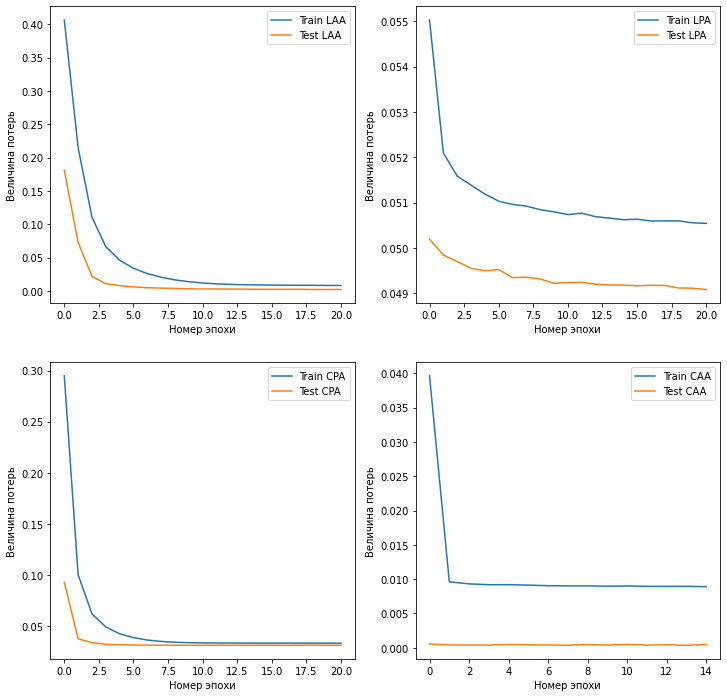

In [25]:
fig, ax =  plt.subplots(2, 2, figsize=(12, 12))

ax[0,0].plot(lossTrainLAA[:],label='Train LAA')
ax[0,0].plot(lossTestLAA[:],label='Test LAA')
ax[0,0].set_xlabel("Номер эпохи")
ax[0,0].set_ylabel("Величина потерь")
ax[0,0].legend()

ax[0,1].plot(lossTrainLPA[:],label='Train LPA')
ax[0,1].plot(lossTestLPA[:],label='Test LPA')
ax[0,1].set_xlabel("Номер эпохи")
ax[0,1].set_ylabel("Величина потерь")
ax[0,1].legend()

ax[1,0].plot(lossTrainCPA[:],label='Train CPA')
ax[1,0].plot(lossTestCPA[:],label='Test CPA')
ax[1,0].set_xlabel("Номер эпохи")
ax[1,0].set_ylabel("Величина потерь")
ax[1,0].legend()

ax[1,1].plot(lossTrainCAA[:],label='Train CAA')
ax[1,1].plot(lossTestCAA[:],label='Test CAA')
ax[1,1].set_xlabel("Номер эпохи")
ax[1,1].set_ylabel("Величина потерь")
ax[1,1].legend()

fig.savefig("loss_regr",dpi=200)

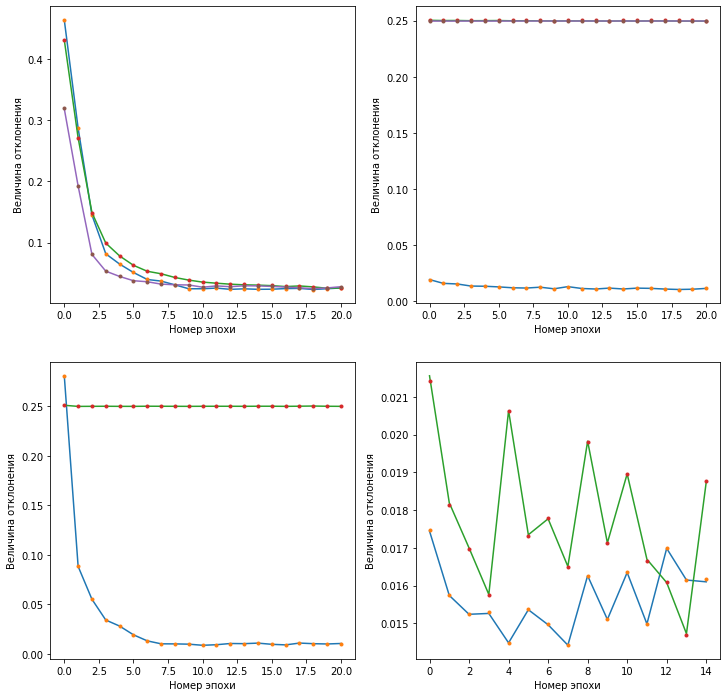

In [27]:
fig, ax =  plt.subplots(2, 2, figsize=(12, 12))


for feature in range(3):
  ax[0,0].plot([i[feature] for i in accTrainLAA])
  ax[0,0].plot([i[feature] for i in accTestLAA],".")
  ax[0,1].plot([i[feature] for i in accTrainLPA])
  ax[0,1].plot([i[feature] for i in accTestLPA],".")
  
for feature in range(2):
  ax[1,0].plot([i[feature] for i in accTrainCPA])
  ax[1,0].plot([i[feature] for i in accTestCPA],".")
  ax[1,1].plot([i[feature] for i in accTrainCAA])
  ax[1,1].plot([i[feature] for i in accTestCAA],".")
  
for local in ax:
  for oneAx in local:
    oneAx.set_xlabel("Номер эпохи")
    oneAx.set_ylabel("Величина отклонения")

fig.savefig("acc_regr",dpi=200)